Model the window correction

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import fitsio as ft
from   glob import glob

In [142]:
plt.rc('font', size=20)

In [12]:
#randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', lower=True)
randoms = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.ran.fits', lower=True)
randoms.dtype.names

('ra',
 'dec',
 'z',
 'weight_fkp',
 'weight_systot',
 'weight_cp',
 'weight_noz',
 'nz')

(array([ 6685.,  8750., 10256., 11956., 11618., 11460., 11528., 10734.,
         9228.,  7785.]),
 array([0.80002975, 0.94002538, 1.08002101, 1.22001664, 1.36001227,
        1.5000079 , 1.64000353, 1.77999916, 1.91999479, 2.05999042,
        2.19998605]),
 <a list of 10 Patch objects>)

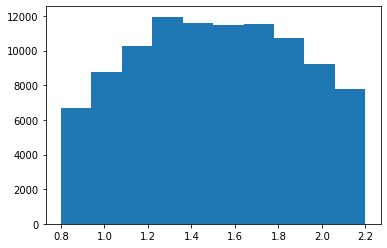

In [22]:
plt.hist(randoms['z'])

In [13]:
# randoms = np.random.choice(randoms, size=10000, replace=False)

In [2]:
import nbodykit.lab as nb

In [5]:
from time import time

In [14]:
randoms = nb.ArrayCatalog(randoms)

In [15]:
randoms.columns

['Selection',
 'Value',
 'Weight',
 'dec',
 'nz',
 'ra',
 'weight_cp',
 'weight_fkp',
 'weight_noz',
 'weight_systot',
 'z']

In [16]:
randoms['Weight'] = randoms['weight_cp']*randoms['weight_noz']*randoms['weight_systot']*randoms['weight_fkp']

In [17]:
randoms.size

100000

In [18]:
def run():
    t0 = time()    
    edges = np.logspace(np.log10(0.1), np.log10(5000.0), 100)
    # edges = np.linspace(0.001, 5000.0, 100)
    cosmo = nb.cosmology.Planck15
    RR    = nb.SurveyDataPairCount('2d', randoms, edges, Nmu=20, cosmo=cosmo, 
                                   ra='ra', dec='dec', redshift='z', weight='Weight',
                                   show_progress=1)
    print('took {} sec'.format(time()-t0))
    return RR

In [19]:
RR = run()

took 266.39410305023193 sec


In [29]:
RR.save('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6_100k.RR.ran.json')

Text(0.5, 0, 'r')

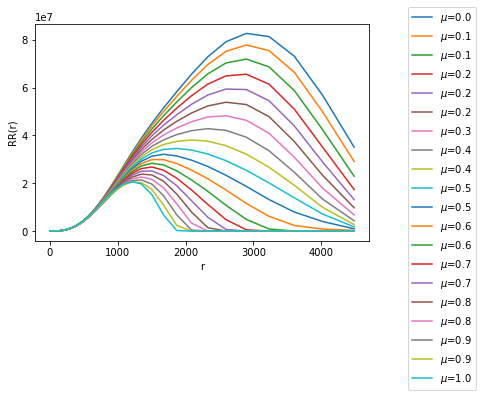

In [20]:
for j, mu_j in enumerate(RR.pairs.edges['mu'][:-1]):
    #print(j)
    plt.plot(RR.pairs.edges['r'][:-1], RR.pairs['wnpairs'][:, j], label=r'$\mu$=%.1f'%mu_j)
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.ylabel('RR(r)')
plt.xlabel('r')

0.0
0.0
0.0


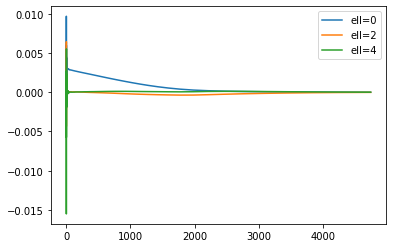

In [27]:
for ell in [0, 2, 4]:
    x   = RR.pairs.edges['r']
    y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
    dx  = np.diff(x)
    xc  = 0.5*(x[1:]+x[:-1])
    vol = 4*np.pi*xc**2*dx    
    y  /= vol
    print(y[0])
    plt.plot(xc, y, label='ell=%d'%ell)
plt.legend()
# plt.xscale('log')
# plt.xlim(xmin=1)

Use SurveyDataPairCount and use Nmu= 100
Inside this SurveyDataPairCount, modify the option for 1d.
And made mode 2d

Make your code so that it addes all different mu bins aftermultiply with Legendre_ell(mu)


In [77]:
edges = np.logspace(np.log10(0.1), np.log10(5000.0), 100)
# edges = np.linspace(0.001, 5000.0, 100)
cosmo = nb.cosmology.Planck15
RR1d    = nb.SurveyDataPairCount('1d', randoms, edges, cosmo=cosmo, 
                               ra='ra', dec='dec', redshift='z', weight='Weight',
                               show_progress=True)

(1, 7657.393122730506)

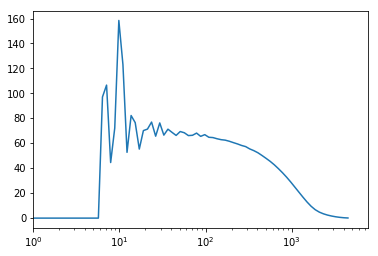

In [86]:
dr = np.diff(edges)
plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
plt.xscale('log')
plt.xlim(xmin=1)

## Florian window

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [31]:
d = np.loadtxt('/Volumes/TimeMachine/data/eboss/v6/win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', skiprows=30)

In [33]:
len(d[0])

18

In [34]:
d.shape

(10000, 18)

In [40]:
lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k) W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k) W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
tlb = lbls.split(' ')
tlb

['W^0_0(k)',
 'W^0_1(k)',
 'W^0_2(k)',
 'W^0_3(k)',
 'W^0_4(k)',
 'W^1_0(k)',
 'W^1_1(k)',
 'W^1_2(k)',
 'W^1_3(k)',
 'W^1_4(k)',
 'W^2_0(k)',
 'W^2_1(k)',
 'W^2_2(k)',
 'W^2_3(k)',
 'W^2_4(k)',
 'Nmodes']

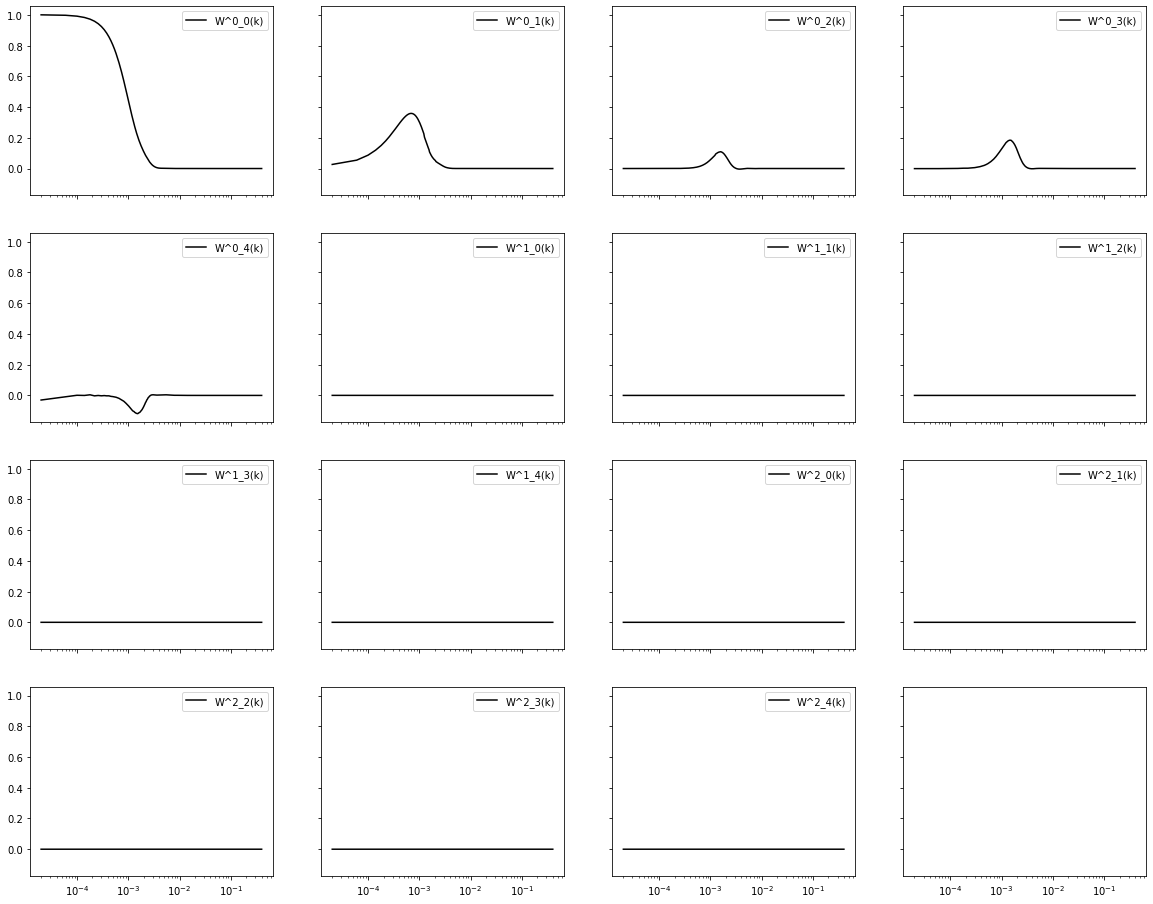

In [44]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 16), sharex=True, sharey=True)
ax = ax.flatten()

w_dicts = {}
for i, j in enumerate(range(2, 17)):
    k = d[:, 0]
    w = d[:, j]
    w_dicts[tlb[i]] = w
    ax[i].plot(k, w, 'k-', label=tlb[i])
    ax[i].set_xscale('log')
    ax[i].legend()

In [46]:
w_r_dicts
for key_i in w_dicts.keys():
    

dict_keys(['W^0_0(k)', 'W^0_1(k)', 'W^0_2(k)', 'W^0_3(k)', 'W^0_4(k)', 'W^1_0(k)', 'W^1_1(k)', 'W^1_2(k)', 'W^1_3(k)', 'W^1_4(k)', 'W^2_0(k)', 'W^2_1(k)', 'W^2_2(k)', 'W^2_3(k)', 'W^2_4(k)'])

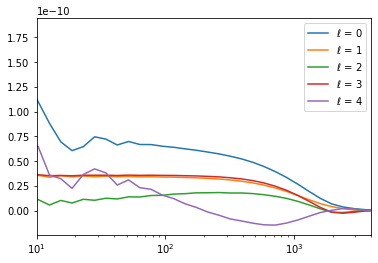

In [75]:


import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

Klog = np.logspace(np.log10(k.min()), np.log10(k.max()))
for l in [0, 1, 2, 3, 4]:
    wius = IUS(k, w_dicts['W^0_%d(k)'%l])
    r, wr = mcfit.P2xi(Klog)(wius(Klog))
    plt.plot(r, wr, label=r'$\ell$ = %d'%l)
plt.xscale('log')
plt.xlim(10, 4e3)
plt.legend()

In [3]:
path2file = '/C/sheejong/Shared/eBOSS_QSO_clustering_NGC_v6.ran'

In [5]:
RR = nb.SurveyDataPairCount.load(path2file)

In [6]:
RR.pairs

<BinnedStatistic: dims: (r: 99, mu: 20), variables: ('r', 'npairs', 'wnpairs')>

In [ ]:
def plot_RRr(RR):
    dr = np.diff(edges)
    plt.plot(edges[:-1], RR1d.pairs['wnpairs']/ ((4*np.pi*edges[:-1]**2*dr)))
    plt.xscale('log')
    plt.xlim(xmin=1)

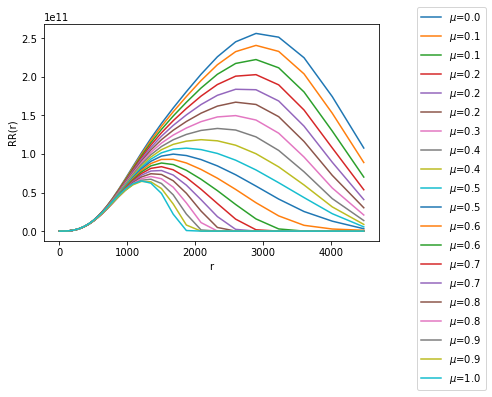

In [13]:
def plot_RRrmu(RR):
    for j, mu_j in enumerate(RR.pairs.edges['mu'][:-1]):
        #print(j)
        plt.plot(RR.pairs.edges['r'][:-1], RR.pairs['wnpairs'][:, j], label=r'$\mu$=%.1f'%mu_j)
    plt.legend(bbox_to_anchor=(1.1, 1.1))
    plt.ylabel('RR(r)')
    plt.xlabel('r')    
plot_RRrmu(RR)

In [65]:
from scipy.special import legendre

def RR_to_ell(RR, mu_bins, ell):
    mu_mid       = 0.5*(mu_bins[:-1]+mu_bins[1:])
    legendre_pol = (2*ell+1.)*legendre(ell)(mu_mid)
    mu_diff      = np.diff(mu_bins) 
    RR_ell       = np.sum(RR * legendre_pol * mu_diff, axis=1) / np.sum(mu_bins)
    return RR_ell    

def plot_RRellr(RR):    
    for ell in [0, 2, 4]:
        x   = RR.pairs.edges['r']
        y   = RR_to_ell(RR.pairs['wnpairs'], RR.pairs.edges['mu'], ell)
        dx  = np.diff(x)
        xc  = 0.5*(x[1:]+x[:-1])
        vol = 4*np.pi*xc**2*dx    
        y  /= vol
        #print(y[0])
        y /= y[3]
        plt.plot(xc, y, label='ell=%d'%ell)
    plt.legend()
    plt.xscale('log')
    plt.xlim(10, 4e3)
    plt.ylim(-1.5, 1.1)
    # plt.xlim(xmin=1)

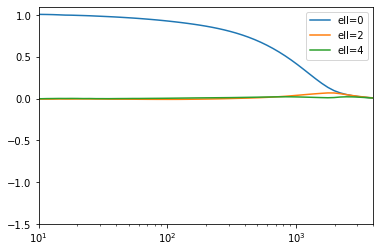

In [66]:
plot_RRellr(RR)

In [20]:
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

lbls = 'W^0_0(k) W^0_1(k) W^0_2(k) W^0_3(k) W^0_4(k) W^1_0(k) W^1_1(k) W^1_2(k) W^1_3(k) W^1_4(k) W^2_0(k) W^2_1(k) W^2_2(k) W^2_3(k) W^2_4(k) Nmodes'
tlb = lbls.split(' ')

def read_florian():    
    d = np.loadtxt('/home/mehdi/data/eboss/v6/win_eBOSS_DR16_QSO_v6_NGC_TSC_600_600_600_10000_merged.dat', 
                   skiprows=30)
    w_dicts = {}
    for i, j in enumerate(range(2, 17)):
        k = d[:, 0]
        w = d[:, j]
        w_dicts[tlb[i]] = w
    return k, w_dicts

In [90]:
k, w_dicts = read_florian()
Klog = np.logspace(np.log10(k.min()), np.log10(k.max()), num=1024, endpoint=True)

In [140]:
def plot_W0ellr(ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(8, 6))
    for ell in [0, 2, 4]:#, 1, 2, 3, 4]:
        wius = IUS(k, w_dicts['W^0_%d(k)'%ell])
        wk   = wius(Klog)
        #for i in range(Klog.size):
        #    print([Klog[i], wk[i]])
        #break
        r, wr = mcfit.P2xi(Klog, l=ell)(wk)
        sf = 1 if ell==2 else 1
        ax.plot(r, sf*wr, label=r'$W^0_%d$'%ell)
    ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    ax.set_xlim(10, 4e3)
    # plt.ylim(0, 2.e-10)
    ax.set_xlabel('r')
    ax.legend(fontsize=20)

In [147]:
def plot_W0ellk(ax=None):
    if ax is None:fig, ax = plt.subplots(figsize=(8, 6))
    for l in [0, 1, 2, 3, 4]:
        w = w_dicts['W^0_%d(k)'%l]
        ax.plot(k, w, label=r'$W^0_%d$'%l)

    ax.axhline(0.0, color='k')
    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 2e-2)
    #ax.set_xlim(1.e-4, 0.5)
    #plt.ylim(0, 2.e-10)
    ax.set_xlabel('k')
    ax.legend(fontsize=20)

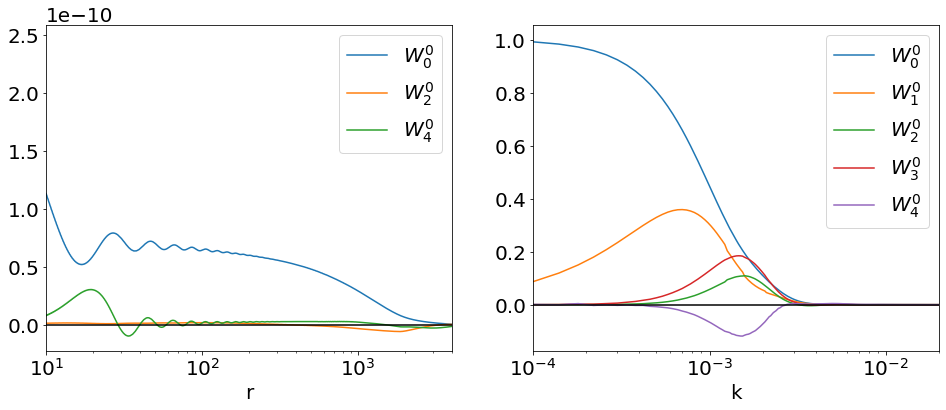

In [149]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
plot_W0ellr(ax=ax[0])
plot_W0ellk(ax=ax[1])